In [794]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance

## 切分男女資料

In [795]:
subject = "geography"  # Change this to the subject you want to predict
# math
# history
# physics
# chemistry
# biology
# english
# geography

sex = "female"
# male
# female

model_select = "lr"  # Change this to the model you want to use
# xgb
# rfr
# lr

if model_select == "xgb":
    model_name = "XGBoost"
elif model_select == "lr":
    model_name = "Linear Regression"
elif model_select == "rfr":
    model_name = "Random Forest"

In [796]:
df = pd.read_csv(f"./gender_subject/{sex}/student_scores_clean_{subject}.csv")

print(f"{sex} students with {subject} score data shape:", df.shape)

y = df

female students with geography score data shape: (958, 21)


In [797]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   part_time_job                 958 non-null    int64
 1   absence_days                  958 non-null    int64
 2   extracurricular_activities    958 non-null    int64
 3   weekly_self_study_hours       958 non-null    int64
 4   geography_score               958 non-null    int64
 5   career_Accountant             958 non-null    int64
 6   career_Artist                 958 non-null    int64
 7   career_Banker                 958 non-null    int64
 8   career_Business Owner         958 non-null    int64
 9   career_Designer               958 non-null    int64
 10  career_Doctor                 958 non-null    int64
 11  career_Game Developer         958 non-null    int64
 12  career_Government Officer     958 non-null    int64
 13  career_Lawyer                 958 n

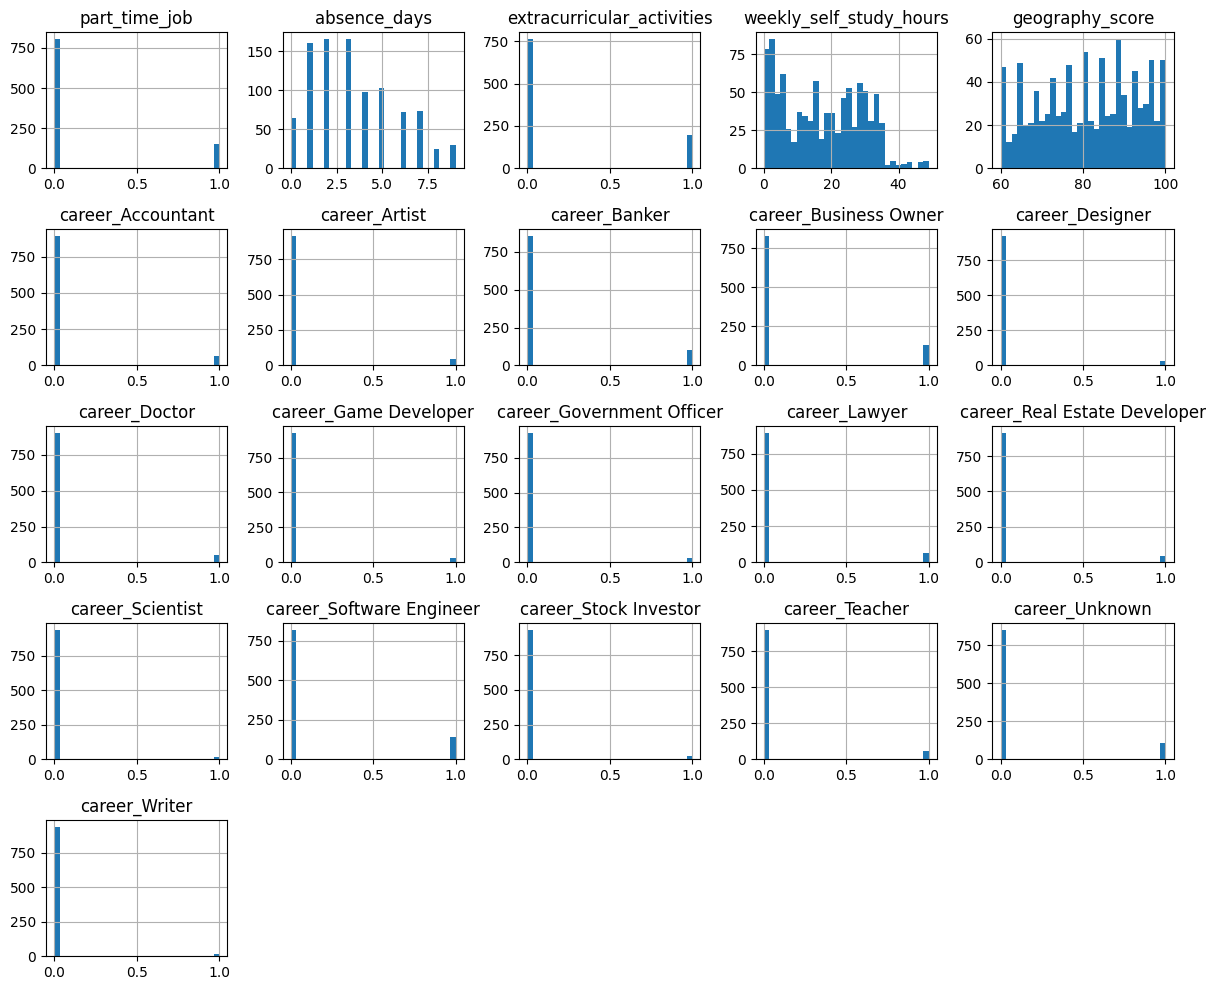

In [798]:
df.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()


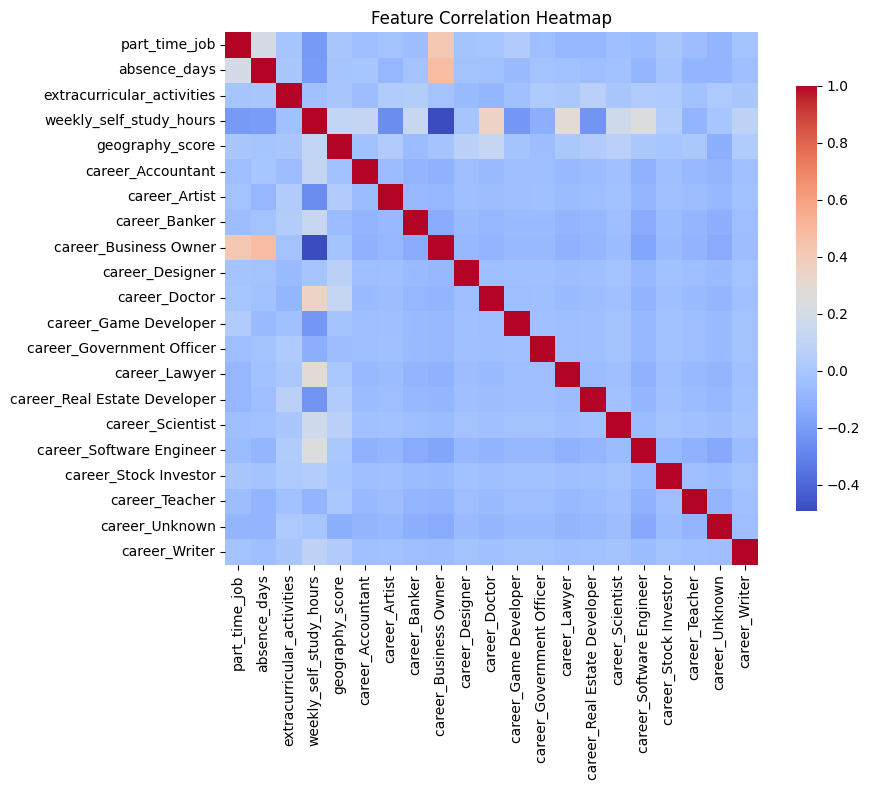

In [799]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 計算特徵間的皮爾森相關係數
corr = df.corr()

# 繪製熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(corr, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [800]:
career_columns = [col for col in df.columns if col.startswith("career_")]

features = [
    "part_time_job",
    "absence_days",
    "extracurricular_activities",
    "weekly_self_study_hours"
] + career_columns

print("Features num:", len(features))

Features num: 20


## 切分科目

In [801]:
X = df[features]



y = df[subject+ "_score"]


## 設定模型

In [802]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [803]:
if model_select == "xgb":
    param_grid = {
        'n_estimators': [100, 300],
        'max_depth': [2, 4, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [0.1, 1]
    }

    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("最佳參數組合 (Best parameters):")
    print(grid_search.best_params_)

    print("最佳模型的負 RMSE (Best negative RMSE):")
    print(grid_search.best_score_)

    best_model = grid_search.best_estimator_

if model_select == "lr":
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    best_model = lr_model
    
if model_select == "rfr":
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    best_model = rf_model

with open(f'{sex}_result/model/{model_select}_{subject}_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

career_Unknown: -4.8090
career_Lawyer: -3.7562
career_Accountant: -3.5660
career_Stock Investor: -3.2827
career_Banker: -2.9600
career_Government Officer: -1.6997
career_Software Engineer: -1.6360
career_Game Developer: -0.9549
absence_days: 0.0344
weekly_self_study_hours: 0.2244
part_time_job: 0.2904
career_Writer: 0.3182
extracurricular_activities: 0.7761
career_Scientist: 1.2188
career_Teacher: 1.3807
career_Doctor: 1.7816
career_Business Owner: 2.9464
career_Real Estate Developer: 4.4123
career_Artist: 4.9025
career_Designer: 5.7040


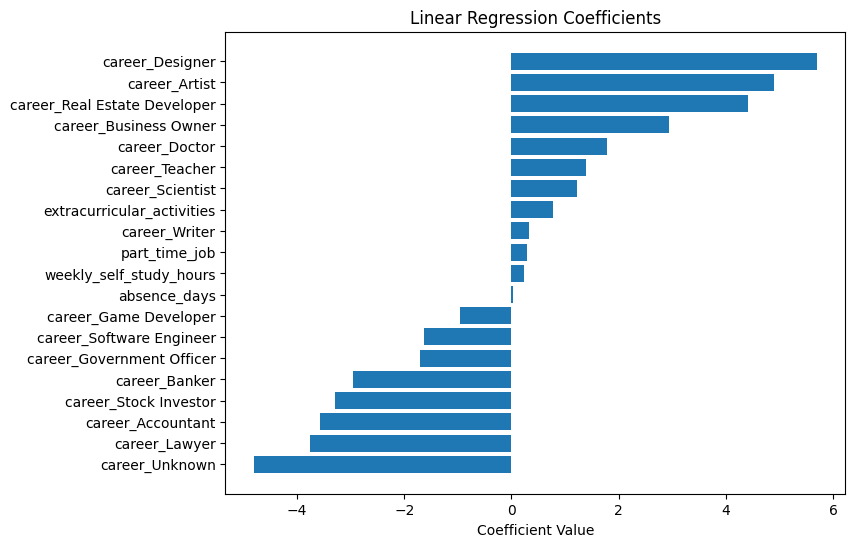

In [804]:
if model_select != "lr":
    importances = best_model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df = importance_df.sort_values(by='importance', ascending=True)

    for _, row in importance_df.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")

    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel("Feature Importance")
    plt.title(f"{model_name} Feature Importance")
    plt.savefig(f"{sex}_result/feature_importance/{model_select}_{subject}.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    coefficients = best_model.coef_
    feature_names = X_train.columns

    lr_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
    lr_df = lr_df.sort_values(by='coefficient', ascending=True)

    for _, row in lr_df.iterrows():
        print(f"{row['feature']}: {row['coefficient']:.4f}")

    plt.figure(figsize=(8, 6))
    plt.barh(lr_df['feature'], lr_df['coefficient'])
    plt.xlabel("Coefficient Value")
    plt.title("Linear Regression Coefficients")
    plt.savefig(f"{sex}_result/feature_importance/{model_select}_{subject}.png", dpi=300, bbox_inches='tight')
    plt.show()

## 預測結果

In [805]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}") # 0~正無限大(越小越好)
print(f"MAE: {mae:.2f}") # 0~正無限大(越小越好)
print(f"R² 分數: {r2:.4f}") # 負無限大~1 (接近1越好)
print(f"RMSE: {rmse:.2f}") # 0~正無限大(越小越好)
print(f"MSE: {mse:.2f}<br>MAE: {mae:.2f}<br>R² 分數: {r2:.4f}<br>RMSE: {rmse:.2f}")

MSE: 121.18
MAE: 9.13
R² 分數: -0.0151
RMSE: 11.01
MSE: 121.18<br>MAE: 9.13<br>R² 分數: -0.0151<br>RMSE: 11.01


In [806]:
mean_score = y_test.mean()
error_pct = rmse / mean_score * 100
print(f"相對誤差: {error_pct:.2f}%")

相對誤差: 13.76%


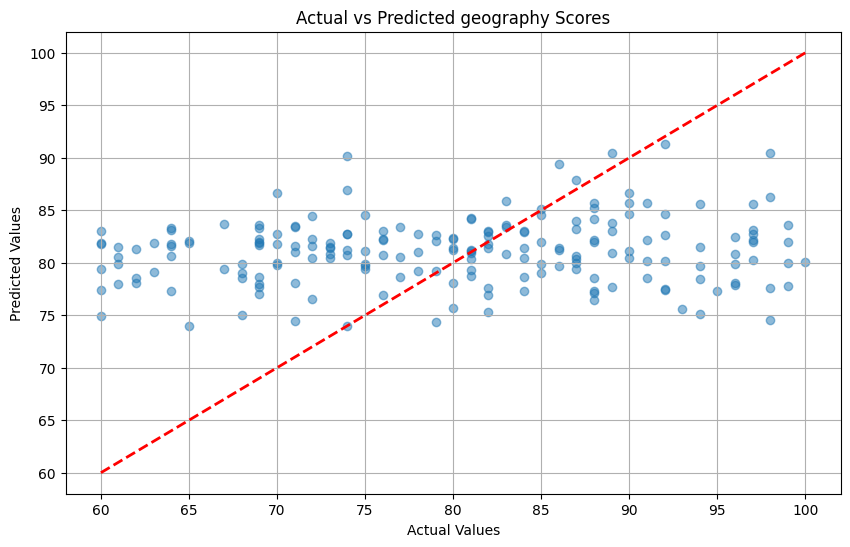

In [807]:
# 繪製實際值與預測值的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Actual vs Predicted {subject} Scores')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.savefig(f"{sex}_result/actual_vs_predict/{model_select}_{subject}_scores.png", dpi=300, bbox_inches='tight')
plt.show()